In [13]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np
from numpy import interp

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Conv2D, Dense, Flatten, GlobalAveragePooling2D


# from keras import backend as K
from tensorflow.keras import backend as K
from keras import models
from tensorflow.keras import utils
from tensorflow.keras import datasets, layers, models


from itertools import cycle


from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# from google.colab import drive

import pathlib

In [14]:
#Se monta la unidad de Google Drive
# drive.mount('/content/gdrive', force_remount=True)

DATA_TRAIN = '/Users/ashleycui/code/dev/deep_learning_project/src/task6/4-facemasks/Dataset/train'
DATA_TEST = '/Users/ashleycui/code/dev/deep_learning_project/src/task6/4-facemasks/Dataset/test'

#Se almacenan los datos de la carpeta Train
# data_train = "/content/gdrive/MyDrive/Codigo_Colab/conjunto-datos/Train"
data_train = pathlib.Path('./Dataset/train')

#Se almacenan los datos de la carpeta Test
# data_test = "/content/gdrive/MyDrive/Codigo_Colab/conjunto-datos/Test"
data_test = pathlib.Path('./Dataset/test')

#Se define el tamaño de entrada de las imagenes
IMAGE_SIZE=(300, 300)
#Se define el tamaño del lote de datos que se utilizara 
BATCH_SIZE=15
datagen_kwargs = dict(rescale=1./255)

In [15]:
#Se utiliza la funcion ImageDataGenerator en conjunto con el diccionario para reescalar las imagenes de prueba
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
#Definimos los operadores para la modificacion de las imagenes en ImageGnerator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode= "nearest",
    **datagen_kwargs)


#Creamos el generador con los datos de prueba
test_generator = test_datagen.flow_from_directory(
    data_test, target_size=IMAGE_SIZE,  color_mode="rgb" ,batch_size=1450,
    class_mode='categorical',
    shuffle=False)
#Generador con los datos de 
train_generator = train_datagen.flow_from_directory(
    data_train, subset="training", shuffle=True, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, color_mode="rgb",
    interpolation="bilinear", class_mode='categorical')

x_test, y_test = next(test_generator)
x_train, y_train = next(train_generator)

Found 330 images belonging to 5 classes.
Found 1956 images belonging to 5 classes.


In [16]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
#Precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
#F1
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 5*((precision*recall)/(precision+recall+K.epsilon()))
#Especificidad
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [17]:
from tensorflow.keras.layers import Lambda

resn_model = tf.keras.applications.ResNet101V2(input_shape=(300, 300,3), include_top=False, weights=None)

resn_model.trainable = True

fine_tune_at = 100
for layer in resn_model.layers[:fine_tune_at]:
    layer.trainable =  False

model = models.Sequential([# Lambda(lambda x: x, input_shape=(300, 300, 3)), 
                    tf.keras.layers.InputLayer((300, 300, 3)),
                                  resn_model,
                    GlobalAveragePooling2D(),
                    Flatten(),
                    Dense(5, activation='softmax')])

model.compile(optimizer= tf.keras.optimizers.SGD(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy', specificity, precision_m, recall_m],
              )

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet101v2 (Functional)        │ (None, 10, 10, 2048)   │    42,626,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │        10,245 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,636,805 (162.65 MB)

 Trainable params: 39,579,653 (150.98 MB)

 Non-trainable params: 3,057,152 (11.66 MB)

In [18]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=5, batch=64, steps_per_epoch=steps_per_epoch).history

Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 620s 5s/step - accuracy: 0.3095 - loss: 1.5548 - precision_m: 0.4105 - recall_m: 0.0664 - specificity: 0.9877
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 617us/step - accuracy: 0.4667 - loss: 1.4257 - precision_m: 0.3599 - recall_m: 0.1679 - specificity: 0.4871
Epoch 3/10


2024-08-15 20:48:08.135294: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/ashleycui/miniconda3/envs/tf2/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


130/130 ━━━━━━━━━━━━━━━━━━━━ 562s 4s/step - accuracy: 0.4075 - loss: 1.3944 - precision_m: 0.6368 - recall_m: 0.1954 - specificity: 0.9697
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 100us/step - accuracy: 0.4000 - loss: 1.4359 - precision_m: 0.2519 - recall_m: 0.1008 - specificity: 0.4787
Epoch 5/10


2024-08-15 20:57:33.880273: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 488s 4s/step - accuracy: 0.4409 - loss: 1.3531 - precision_m: 0.6361 - recall_m: 0.2110 - specificity: 0.9668
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 76us/step - accuracy: 0.2667 - loss: 1.2720 - precision_m: 0.2015 - recall_m: 0.0672 - specificity: 0.4787
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 498s 4s/step - accuracy: 0.4671 - loss: 1.3099 - precision_m: 0.6394 - recall_m: 0.2518 - specificity: 0.9644
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 424us/step - accuracy: 0.4000 - loss: 1.1022 - precision_m: 0.3599 - recall_m: 0.1679 - specificity: 0.4871
Epoch 9/10


2024-08-15 21:14:08.227832: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


130/130 ━━━━━━━━━━━━━━━━━━━━ 541s 4s/step - accuracy: 0.4746 - loss: 1.2774 - precision_m: 0.6608 - recall_m: 0.2684 - specificity: 0.9636
Epoch 10/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 394us/step - accuracy: 0.4667 - loss: 1.0869 - precision_m: 0.4319 - recall_m: 0.2015 - specificity: 0.4954


In [19]:
#Creacion de la matriz de confusion
y_pred=model.predict(x_test, batch_size=BATCH_SIZE)
y_pred = np.argmax(y_pred, axis=1)
cm=confusion_matrix(test_generator.classes, y_pred)
print(cm)
#Impresion de la exactitud
accu = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
accu =accu.diagonal()
print(accu)
#Reporte de metricas
target_names = ['KN95', 'N95', 'Generico', 'Quirurgico', 'Sin_cubrebocas']
print(classification_report(test_generator.classes, y_pred, target_names=target_names, digits=4))

loss, accuracy, specificity, precision, recall = model.evaluate(test_generator, verbose=0)
print(loss, accuracy)

22/22 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step
[[19  3 14 42  0]
 [16  4 12 18  0]
 [ 5 20  7 17  0]
 [ 3  1  6 68  0]
 [ 8  1 30 34  2]]
[0.24358974 0.08       0.14285714 0.87179487 0.02666667]
                precision    recall  f1-score   support

          KN95     0.3725    0.2436    0.2946        78
           N95     0.1379    0.0800    0.1013        50
      Generico     0.1014    0.1429    0.1186        49
    Quirurgico     0.3799    0.8718    0.5292        78
Sin_cubrebocas     1.0000    0.0267    0.0519        75

      accuracy                         0.3030       330
     macro avg     0.3984    0.2730    0.2191       330
  weighted avg     0.4411    0.3030    0.2395       330



/Users/ashleycui/miniconda3/envs/tf2/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1.6617261171340942 0.3030303120613098


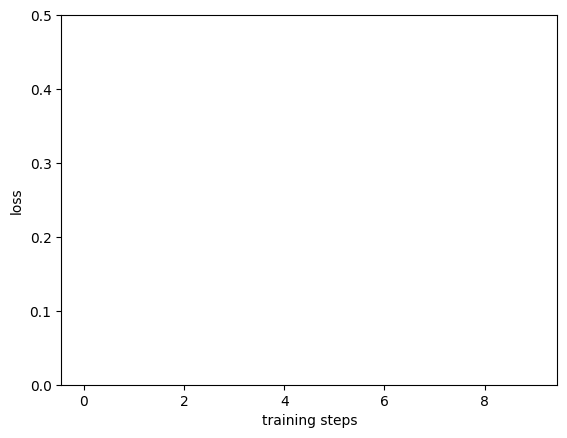

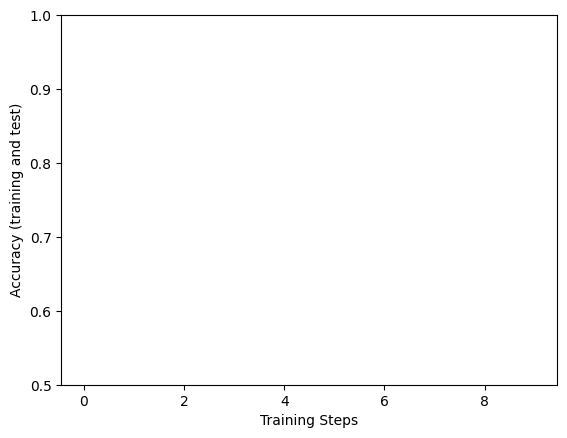

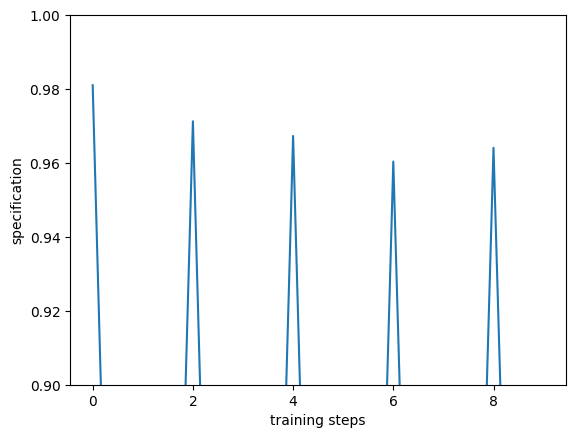

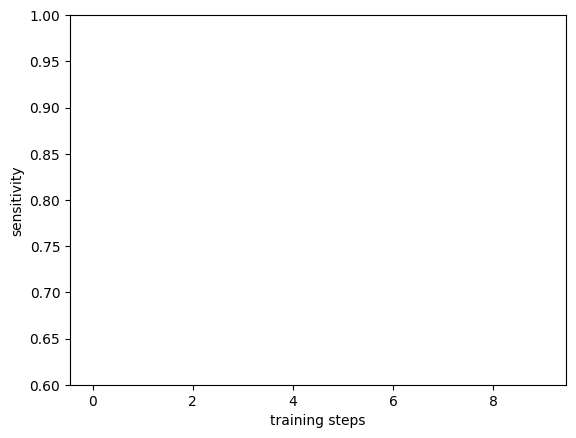

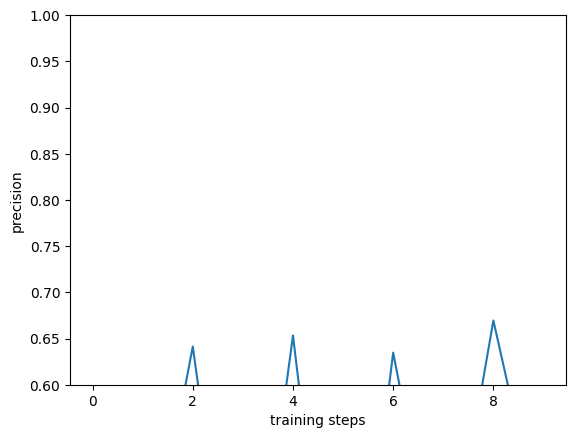

In [21]:
plt.figure()
plt.ylabel("loss")
plt.xlabel("training steps")
plt.ylim([0,0.5])
plt.plot(hist["loss"])

plt.figure()
plt.ylabel("Accuracy (training and test)")
plt.xlabel("Training Steps")
plt.ylim([0.5,1])
plt.plot(hist["accuracy"])

plt.figure()
plt.ylabel("specification")
plt.xlabel("training steps")
plt.ylim([0.9,1])
plt.plot(hist["specificity"])

plt.figure()
plt.ylabel("sensitivity")
plt.xlabel("training steps")
plt.ylim([0.6,1])
plt.plot(hist["recall_m"])

plt.figure()
plt.ylabel("precision")
plt.xlabel("training steps")
plt.ylim([0.6,1])
plt.plot(hist["precision_m"])

11/11 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step


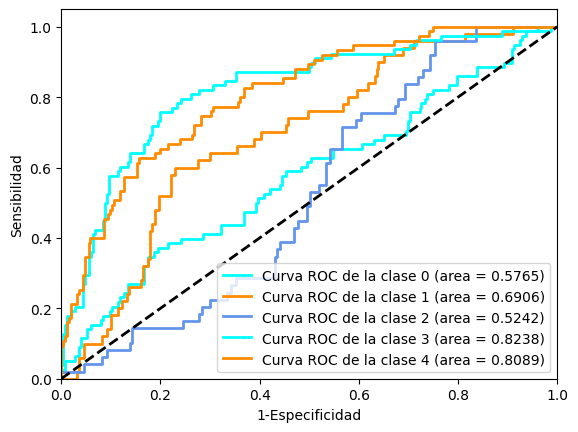

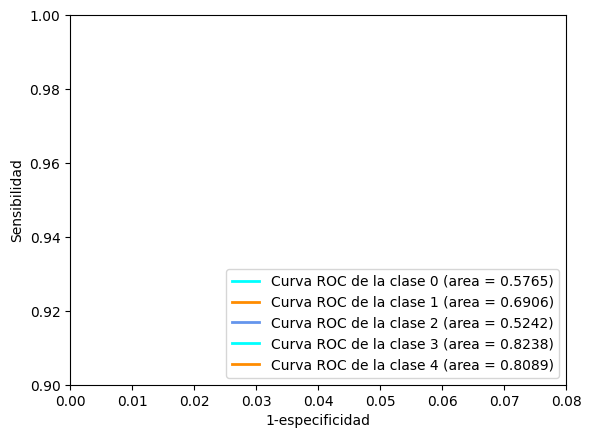

In [22]:
import matplotlib.pyplot as plt

# Impresion de la curva ROC
lw = 2
y_score = model.predict(x_test)
n_classes= 5
# Calcular la curva ROC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculo de curva ROC Micropromedio y el area ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Calculo la curva ROC macro-promedio y el área ROC

# Agregar las tasas de los falsos positivos
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Luego interpole todas las curvas ROC en estos puntos
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Promedio y calcule el AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Graficacion de las cruvas por clase
plt.figure(1)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Curva ROC de la clase {0} (area = {1:0.4f})'
                   ''.format(i, roc_auc[i]))

#Primer grafica de curvas ROC
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('Sensibilidad')
plt.xlabel('1-Especificidad')
plt.legend(loc="lower right")
plt.show()

#Zoom de la primer grafica 
plt.figure(2)
plt.xlim(0, 0.08)
plt.ylim(0.9, 1)


colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='Curva ROC de la clase {0} (area = {1:0.4f})'
                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.ylabel('Sensibilidad')
plt.xlabel('1-especificidad')

plt.legend(loc="lower right")

330
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


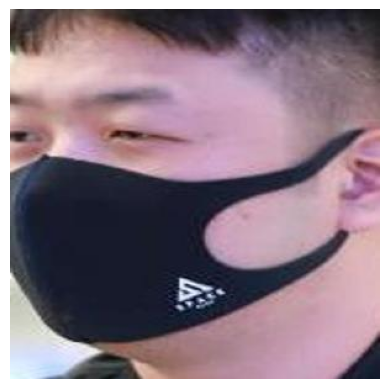

True label: cloth
Predicted label: nfm
Confidence: 0.7459917
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


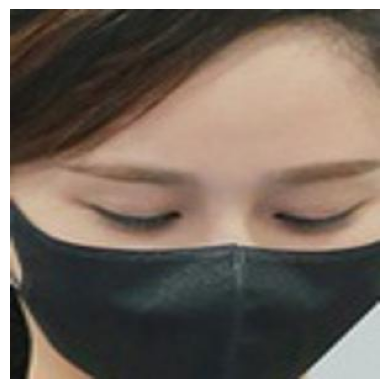

True label: cloth
Predicted label: nfm
Confidence: 0.9325476
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


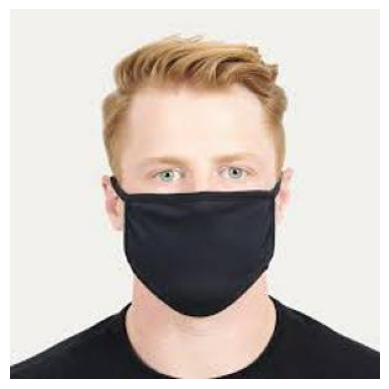

True label: cloth
Predicted label: nfm
Confidence: 0.8601381
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


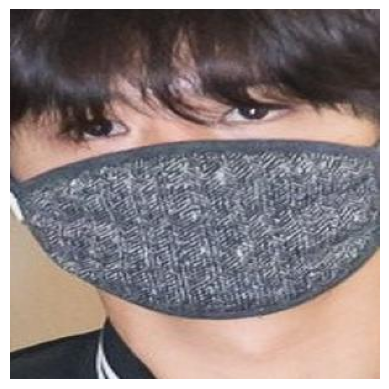

True label: cloth
Predicted label: nfm
Confidence: 0.3847635
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


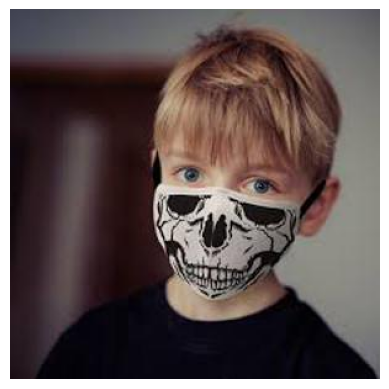

True label: cloth
Predicted label: nfm
Confidence: 0.69222283
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


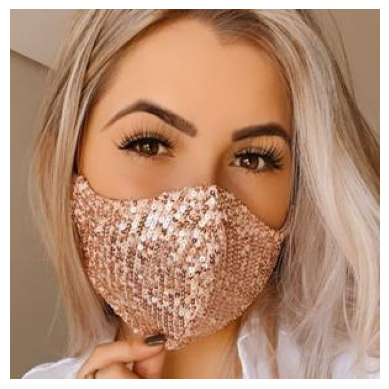

True label: cloth
Predicted label: n95v
Confidence: 0.52205294
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


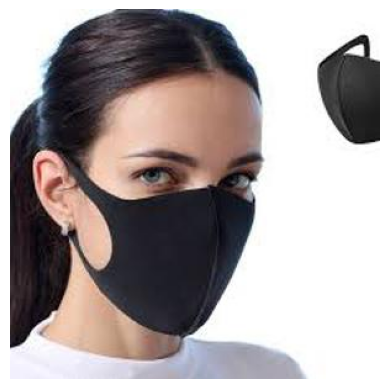

True label: cloth
Predicted label: nfm
Confidence: 0.6458076
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


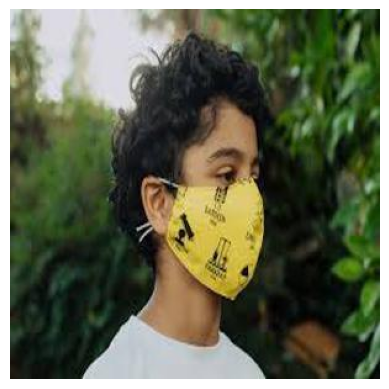

True label: cloth
Predicted label: nfm
Confidence: 0.7576927


In [24]:
#Obtener aquellas imagenes mal clasificadas por el modelo
def get_class_string_from_index(index):
    for class_string, class_index in test_generator.class_indices.items():
        if class_index == index:
            return class_string

count=0
print(len(x_test))
while count < 10:
    image = x_test[count,: , :, :]
    true_index = np.argmax(y_test[count])

    prediction_scores = model.predict(np.expand_dims(image, axis=0))
    predicted_index = np.argmax(prediction_scores)
    confidence= np.amax(prediction_scores)
    if true_index != predicted_index:
        plt.imshow(image)
        plt.axis('off')
        plt.show()
        print("True label: " + get_class_string_from_index(true_index))
        print("Predicted label: " + get_class_string_from_index(predicted_index))
        print("Confidence: " + str(confidence))
    count+=1

In [ ]:
model.save("./n.h5", save_format="h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model6)
tflite_model = converter.convert()
#convertir el modelo a archivo tflite
with open('/content/gdrive/MyDrive/modelo_Nas.tflite', 'wb') as f:
    f.write(tflite_model)